
Przykładowe dane po naprawie (head):
                 name SAE_Type    k    lambda
0       summer-moon-5     TopK   16       NaN
1      charmed-frog-6     TopK   32       NaN
2   ancient-pyramid-7     TopK   64       NaN
3      cosmic-disco-8     TopK  128       NaN
4        daily-wind-9     TopK  256       NaN
5  faithful-yogurt-10     ReLU   32  0.000100
6      honest-tree-11     ReLU   32  0.000300
7   crimson-sunset-12     ReLU   32  0.000600
8    comic-pyramid-13     ReLU   32  0.000010
9    summer-donkey-14     ReLU   32  0.000001
Optymalizacja rozmieszczenia 28 etykiet...


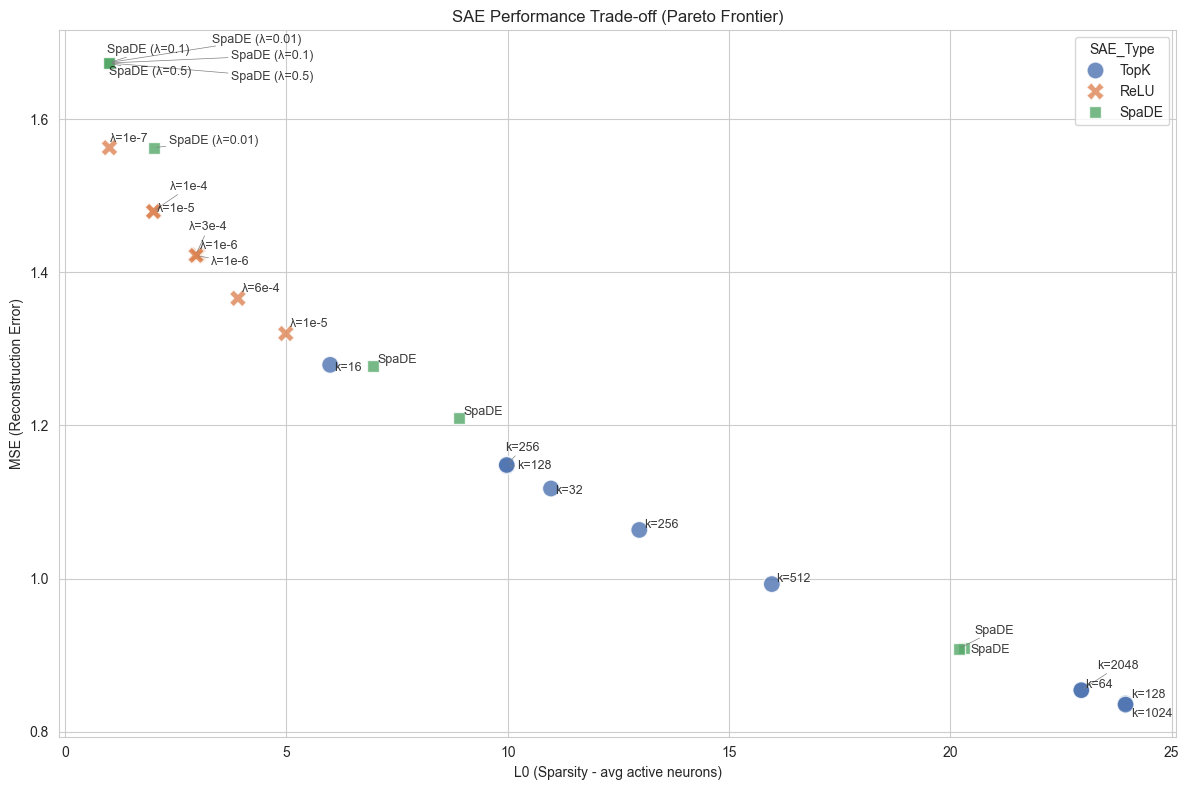

In [7]:
# /// script
# dependencies = ["wandb", "pandas", "matplotlib", "seaborn", "adjustText"]
# ///

import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# ==========================================
# 1. TWOJE DANE (SOURCE OF TRUTH)
# ==========================================

experiments_definition = [
    # --- TopK SAE ---
    { "name": "TopK_k16", "args": ["--SAE", "TopK", "--k", "256"] },
    { "name": "TopK_k32", "args": ["--SAE", "TopK", "--k", "512"] },
    { "name": "TopK_k64", "args": ["--SAE", "TopK", "--k", "1024"] },
    { "name": "TopK_k128", "args": ["--SAE", "TopK", "--k", "2048"] },

    # --- ReLU SAE ---
    { "name": "ReLU_L1_1e-4", "args": ["--SAE", "ReLU", "--lambda_val", "0.0000001"] },
    { "name": "ReLU_L1_3e-4", "args": ["--SAE", "ReLU", "--lambda_val", "0.00000001"] },
    { "name": "ReLU_L1_6e-4", "args": ["--SAE", "ReLU", "--lambda_val", "0.000000001"] },

    # --- SpaDE ---
    { "name": "SpaDE_HighInit_10", "args": ["--SAE", "SpaDE", "--lambda_val", "0.0025"] },
    { "name": "SpaDE_LowInit_0.1", "args": ["--SAE", "SpaDE", "--lambda_val", "1"] },
    { "name": "SpaDE_FixedHigh_20", "args": ["--SAE", "SpaDE", "--lambda_val", "2", "--fix_lambda"] },
]

def build_override_dict(exp_list):
    """
    Parsuje listę argumentów na słownik konfiguracyjny,
    żeby naprawić błędne logi z WandB.
    """
    overrides = {}
    for exp in exp_list:
        args = exp["args"]
        config = {}
        
        # Prosty parser argumentów CLI
        if "--SAE" in args:
            idx = args.index("--SAE") + 1
            config["SAE"] = args[idx]
            
        if "--k" in args:
            idx = args.index("--k") + 1
            config["k"] = int(args[idx])
            
        if "--lambda_val" in args:
            idx = args.index("--lambda_val") + 1
            config["lambda_val"] = float(args[idx])
            
        overrides[exp["name"]] = config
    return overrides

# ==========================================
# 2. USTAWIENIA PROJEKTU
# ==========================================

ENTITY = "molocchus-university-of-warsaw"
PROJECT = "sae-sweep-final"
OVERRIDES = build_override_dict(experiments_definition)

def get_wandb_data():
    api = wandb.Api()
    runs = api.runs(f"{ENTITY}/{PROJECT}")
    
    summary_list = [] 
    
    print(f"Pobieranie danych z {len(runs)} eksperymentów...")

    for run in runs:
        # Sprawdzamy, czy run ma metryki walidacyjne
        if "val/MSE" in run.summary and "val/L0" in run.summary:
            
            # --- LOGIKA NADPISYWANIA ---
            # Domyślnie bierzemy z WandB
            sae_type = run.config.get("SAE")
            k = run.config.get("k")
            lam = run.config.get("lambda_val")
            
            # Jeśli nazwa runu jest w naszej liście naprawczej, używamy jej wartości
            if run.name in OVERRIDES:
                # print(f"Naprawianie danych dla: {run.name}") # Opcjonalny debug
                correct_cfg = OVERRIDES[run.name]
                sae_type = correct_cfg.get("SAE", sae_type)
                k = correct_cfg.get("k", k)
                lam = correct_cfg.get("lambda_val", lam)
            # ---------------------------

            summary_list.append({
                "name": run.name,
                "SAE_Type": sae_type,
                "k": k,
                "lambda": lam,
                "val_MSE": run.summary.get("val/MSE"),
                "val_L0": run.summary.get("val/L0")
            })
            
    return pd.DataFrame(summary_list)

def plot_pareto(df):
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    ax = plt.gca()

    # Rysowanie punktów
    sns.scatterplot(
        data=df, 
        x="val_L0", 
        y="val_MSE", 
        hue="SAE_Type", 
        style="SAE_Type", 
        s=150,
        palette="deep",
        alpha=0.8,
        ax=ax
    )
    
    texts = []
    
    # Generowanie etykiet
    for i, row in df.iterrows():
        label = ""
        sae_type = row["SAE_Type"]
        
        # Logika etykietowania
        if sae_type == "TopK":
            if pd.notna(row['k']):
                 label = f"k={int(row['k'])}"
                 
        elif sae_type == "ReLU":
            val = row['lambda']
            if pd.notna(val):
                # Obsługa bardzo małych liczb (np. 1e-9)
                label = f"λ={val:.0e}" if val < 0.001 else f"λ={val:.2f}"
                # Usuwamy zbędne zera po e (np. 1e-07 -> 1e-7) dla czystości
                label = label.replace("e-0", "e-") 
                
        elif sae_type == "SpaDE":
            val = row['lambda']
            if pd.notna(val):
                 label = f"SpaDE (λ={val})"
            else:
                 label = "SpaDE"
            
        if label:
            t = ax.text(row["val_L0"], row["val_MSE"], label, fontsize=9, alpha=0.9)
            texts.append(t)

    print(f"Optymalizacja rozmieszczenia {len(texts)} etykiet...")
    
    # adjust_text zrobi robotę z nakładaniem się
    adjust_text(texts,
                arrowprops=dict(arrowstyle='-', color='grey', lw=0.5),
                ax=ax
               )

    plt.title("SAE Performance Trade-off (Pareto Frontier)")
    plt.xlabel("L0 (Sparsity - avg active neurons)")
    plt.ylabel("MSE (Reconstruction Error)")
    
    # Opcjonalnie skala logarytmiczna, jeśli L0 lub MSE różnią się o rzędy wielkości
    # plt.xscale('log') 
    # plt.yscale('log')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # df = get_wandb_data()

    df = pd.read_csv('df.csv')
    
    if not df.empty:
        # Konwersja na liczby (bezpiecznik)
        df['val_L0'] = pd.to_numeric(df['val_L0'], errors='coerce')
        df['val_MSE'] = pd.to_numeric(df['val_MSE'], errors='coerce')
        df = df.dropna(subset=['val_L0', 'val_MSE'])
        
        print(f"\nPrzykładowe dane po naprawie (head):\n{df[['name', 'SAE_Type', 'k', 'lambda']].head(10)}")
        plot_pareto(df)
    else:
        print("Brak danych.")

In [6]:
df.to_csv('df.csv')

In [8]:
winners

array([1, 2, 2, ..., 1, 2, 0], shape=(4000,))

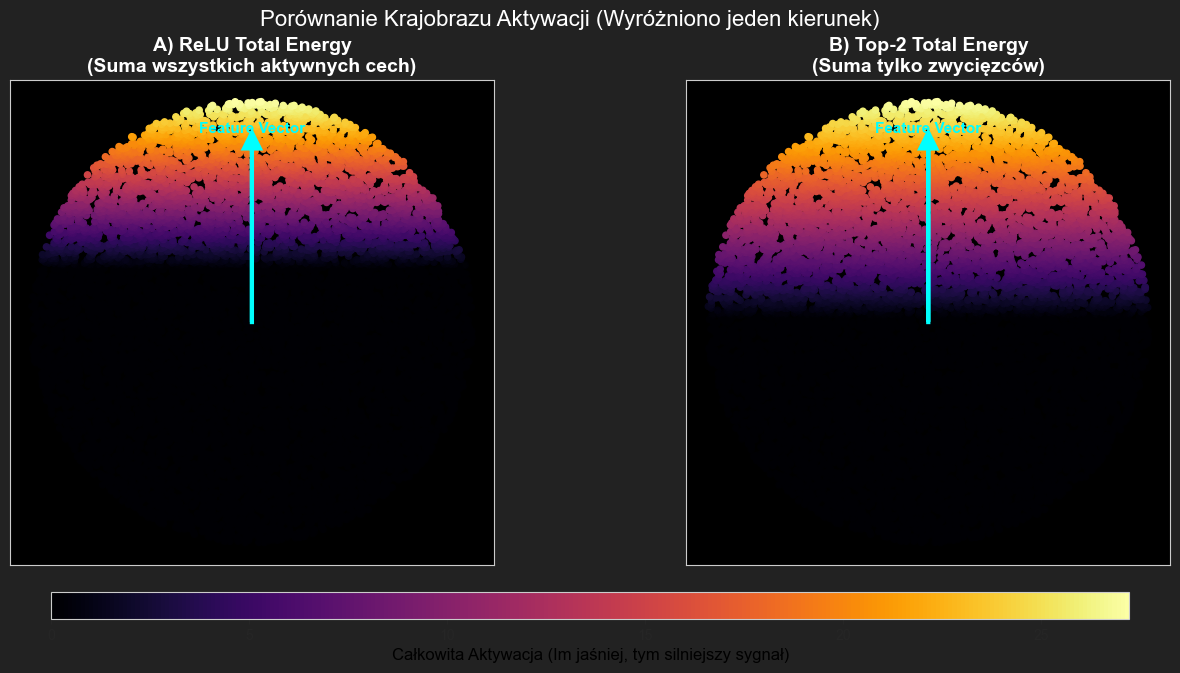

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Konfiguracja Danych i Modelu ---
np.random.seed(42)
n_samples = 10000 # Bardzo gęsta chmura dla płynnego efektu
# Punkty w kole
r = np.sqrt(np.random.rand(n_samples)) * 2.8
theta = np.random.rand(n_samples) * 2 * np.pi
X = np.c_[r * np.cos(theta), r * np.sin(theta)]

# UKRYTE CECHY (Hidden Features)
# Używamy 3 cech do obliczeń, żeby mapa była ciekawa (miała "górki i doliny")
angles = np.radians([90])
W_hidden = np.c_[np.cos(angles), np.sin(angles)]

# CECHA DO WIZUALIZACJI (Ta jedna strzałka)
# Wybieramy pierwszą cechę (skierowaną w górę, 90 stopni)
vector_to_show = W_hidden[0]

# --- 2. Obliczenia Energii (Total Activation) ---

# A) ReLU (Standard)
bias = -0.7
# Iloczyn z wszystkimi ukrytymi cechami
relu_pre = np.dot(X, W_hidden.T) + bias
relu_act = np.maximum(0, relu_pre)
# Suma aktywacji (energia)
energy_relu = np.sum(relu_act, axis=1)

# A) ReLU (Standard)
bias = -0.7
# Iloczyn z wszystkimi ukrytymi cechami
relu_pre = np.dot(X, W_hidden.T) + bias
relu_act = np.maximum(0, relu_pre)
# Suma aktywacji (energia)
energy_topk = np.sum(relu_act, axis=1)

# --- 3. Wizualizacja (Jedna strzałka na panel) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
cmap = 'inferno' # Czerń -> Ogień -> Jasny Żółty

def plot_one_arrow_energy(ax, energy, title):
    # Sortujemy punkty, żeby najjaśniejsze były na wierzchu
    sort_idx = np.argsort(energy)
    
    # Rysujemy mapę ciepła
    sc = ax.scatter(X[sort_idx, 0], X[sort_idx, 1], c=energy[sort_idx], 
                    cmap=cmap, s=20, alpha=1.0, vmin=0)
    
    # Rysujemy TYLKO JEDNĄ strzałkę (wyróżnioną cechę)
    ax.arrow(0, 0, vector_to_show[0]*2.2, vector_to_show[1]*2.2, 
             head_width=0.2, head_length=0.2,
             fc='cyan', ec='cyan', linewidth=3, zorder=10)
    
    # Dodajemy mały opis przy strzałce
    ax.text(vector_to_show[0]*2.4, vector_to_show[1]*2.4, "Feature Vector", 
            color='cyan', fontsize=11, fontweight='bold', ha='center')

    ax.set_title(title, fontsize=14, fontweight='bold', color='white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    # Ustawiamy ciemne tło dla lepszego kontrastu "ognia"
    ax.set_facecolor('black')
    return sc

# Panel Lewy: ReLU
plot_one_arrow_energy(axes[0], energy_relu, "A) ReLU Total Energy\n(Suma wszystkich aktywnych cech)")

# Panel Prawy: Top-K
sc = plot_one_arrow_energy(axes[1], energy_topk, "B) Top-2 Total Energy\n(Suma tylko zwycięzców)")

# Wspólny pasek kolorów
cbar = fig.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05, aspect=40)
cbar.set_label('Całkowita Aktywacja (Im jaśniej, tym silniejszy sygnał)', color='black', fontsize=12)

fig.patch.set_facecolor('#222222') # Ciemne tło całej figury
plt.suptitle("Porównanie Krajobrazu Aktywacji (Wyróżniono jeden kierunek)", fontsize=16, color='white', y=0.98)
plt.show()

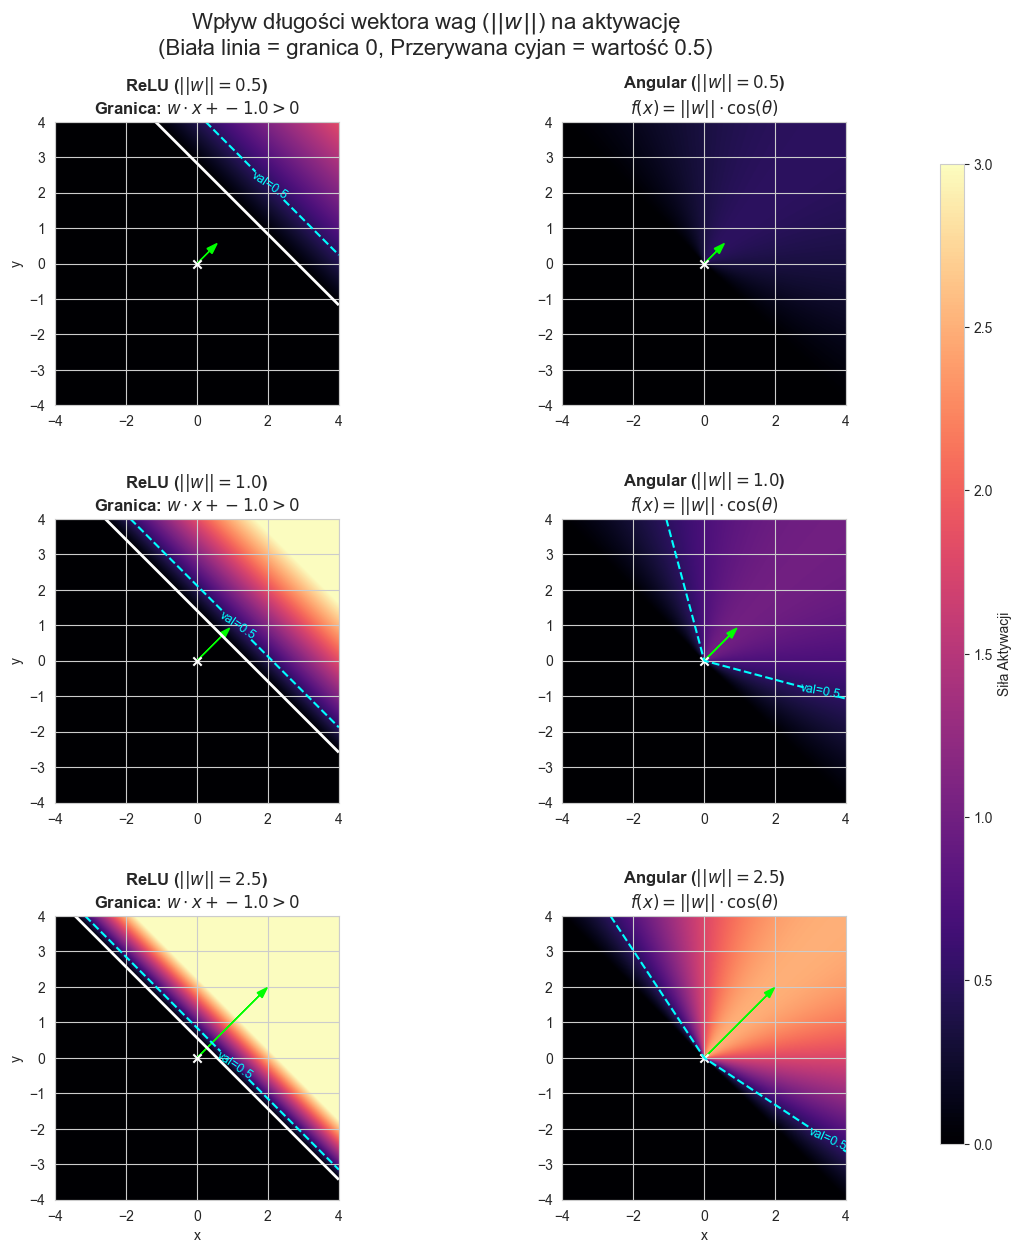

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- Konfiguracja Przestrzeni ---
res = 400
range_limit = 4
x = np.linspace(-range_limit, range_limit, res)
y = np.linspace(-range_limit, range_limit, res)
xx, yy = np.meshgrid(x, y)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Normy punktów w przestrzeni (dla Angular)
point_norms = np.linalg.norm(grid_points, axis=1)
point_norms[point_norms == 0] = 1e-10

# Kierunek wektora (stały - prawy górny róg)
w_base = np.array([1.0, 1.0])
w_dir = w_base / np.linalg.norm(w_base)

# Parametry
norms_to_test = [0.5, 1.0, 2.5] # Testujemy 3 długości wektora
bias = -1.0                     # Stały bias dla ReLU
fixed_threshold = 0.5           # Stały próg izolini (dla wizualizacji zasięgu)

# --- Rysowanie ---
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
plt.subplots_adjust(hspace=0.4)

# Globalne ustawienia kolorów (żeby skala była ta sama na wszystkich wykresach)
vmax_val = 3.0 
cmap = 'magma'

for i, norm_val in enumerate(norms_to_test):
    # Skalujemy wektor wag
    w = w_dir * norm_val
    
    # ---------------------------
    # 1. Obliczenia ReLU
    # ---------------------------
    # Act = max(0, w*x + b)
    linear_act = np.dot(grid_points, w) + bias
    relu_map = np.maximum(0, linear_act).reshape(xx.shape)
    
    # ---------------------------
    # 2. Obliczenia Angular (Projekcja na sferę * norma wagi)
    # ---------------------------
    # W SAE często używa się: (x/|x|) * w. 
    # To to samo co: cos(theta) * |w|
    # Dzięki temu norma wagi ma znaczenie dla siły aktywacji!
    dot_products = np.dot(grid_points, w)
    angular_map = dot_products / point_norms
    angular_map = angular_map.reshape(xx.shape)
    # Wizualizujemy tylko dodatnie dopasowanie (przód)
    angular_map_vis = np.maximum(0, angular_map)

    # ---------------------------
    # Wizualizacja: Kolumna lewa (ReLU)
    # ---------------------------
    ax_relu = axes[i, 0]
    im1 = ax_relu.imshow(relu_map, extent=[-range_limit, range_limit, -range_limit, range_limit], 
                         origin='lower', cmap=cmap, vmin=0, vmax=vmax_val)
    
    # Rysujemy granicę (Gdzie aktywacja = 0)
    ax_relu.contour(xx, yy, linear_act.reshape(xx.shape), levels=[0], colors='white', linewidths=2)
    # Rysujemy izolinię stałego progu (np. gdzie wyjście = 0.5)
    cs = ax_relu.contour(xx, yy, relu_map, levels=[fixed_threshold], colors='cyan', linestyles='dashed')
    ax_relu.clabel(cs, fmt=f'val={fixed_threshold}', fontsize=9)
    
    # Wektor
    ax_relu.arrow(0, 0, w[0], w[1], head_width=0.2, fc='lime', ec='lime', label='Wektor W')
    ax_relu.scatter(0, 0, c='white', marker='x')
    
    ax_relu.set_title(f"ReLU ($||w|| = {norm_val}$)\nGranica: $w \\cdot x + {bias} > 0$", fontweight='bold')
    if i == 2: ax_relu.set_xlabel("x")
    ax_relu.set_ylabel("y")

    # ---------------------------
    # Wizualizacja: Kolumna prawa (Angular)
    # ---------------------------
    ax_ang = axes[i, 1]
    im2 = ax_ang.imshow(angular_map_vis, extent=[-range_limit, range_limit, -range_limit, range_limit], 
                        origin='lower', cmap=cmap, vmin=0, vmax=vmax_val)
    
    # Rysujemy izolinię stałego progu (Gdzie aktywacja = fixed_threshold)
    # To pokaże jak poszerza się stożek!
    if np.max(angular_map_vis) > fixed_threshold:
        cs2 = ax_ang.contour(xx, yy, angular_map_vis, levels=[fixed_threshold], colors='cyan', linestyles='dashed')
        ax_ang.clabel(cs2, fmt=f'val={fixed_threshold}', fontsize=9)
    
    # Wektor
    ax_ang.arrow(0, 0, w[0], w[1], head_width=0.2, fc='lime', ec='lime')
    ax_ang.scatter(0, 0, c='white', marker='x')
    
    ax_ang.set_title(f"Angular ($||w|| = {norm_val}$)\n$f(x) = ||w|| \\cdot \\cos(\\theta)$", fontweight='bold')
    if i == 2: ax_ang.set_xlabel("x")

# Pasek kolorów
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Siła Aktywacji')

plt.suptitle(f"Wpływ długości wektora wag ($||w||$) na aktywację\n(Biała linia = granica 0, Przerywana cyjan = wartość {fixed_threshold})", fontsize=16, y=0.96)
plt.show()

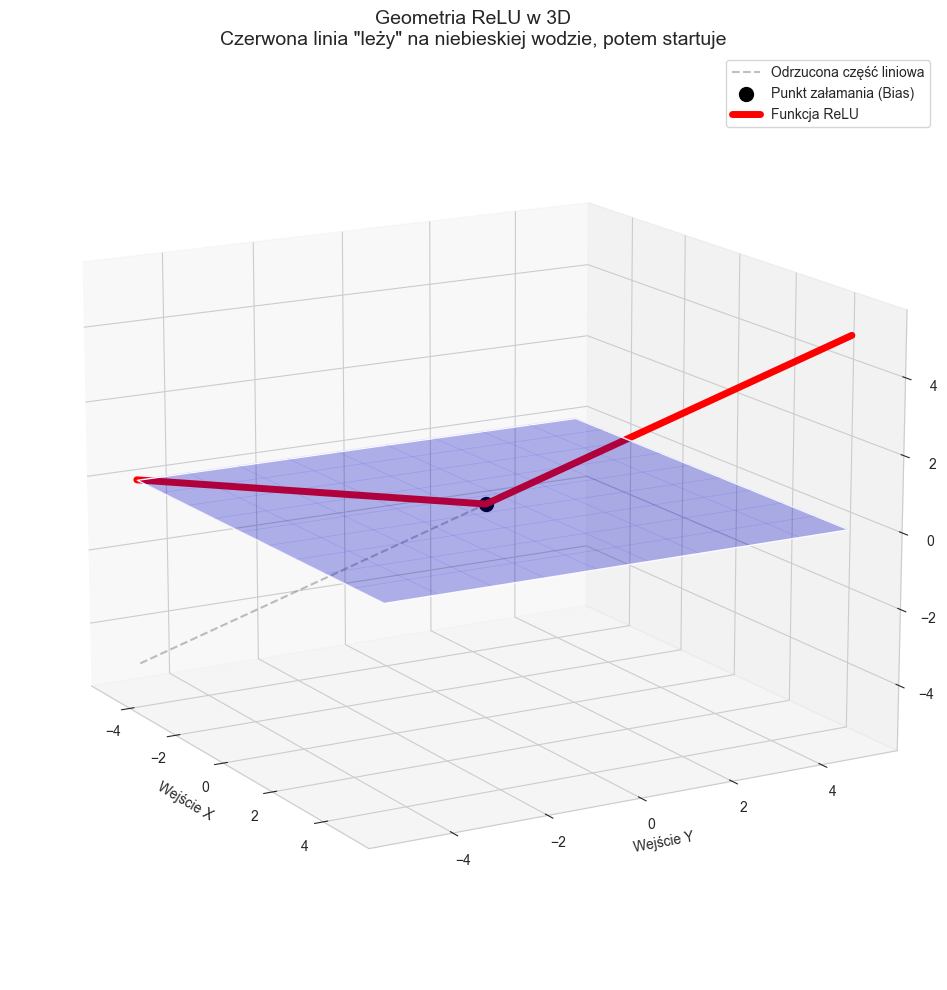

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

# Zasięg osi
limit = 5

# --- 1. Niebieska Płaszczyzna Z=0 (Podłoga) ---
# Tworzymy siatkę punktów dla płaszczyzny
xx, yy = np.meshgrid(np.linspace(-limit, limit, 10), np.linspace(-limit, limit, 10))
zz = np.zeros_like(xx)

# Rysujemy półprzezroczystą niebieską powierzchnię
ax.plot_surface(xx, yy, zz, color='blue', alpha=0.3, rstride=100, cstride=100)
# Dodajemy też siatkę (wireframe) dla lepszej czytelności
ax.plot_wireframe(xx, yy, zz, color='blue', alpha=0.1, linewidth=0.5)

# --- 2. Czerwona Linia ReLU ---
# Parametr t idzie wzdłuż przekątnej x=y
t = np.linspace(-limit, limit, 500)

x_line = t
y_line = t
z_line = np.maximum(0, t) # ReLU: 0 dla ujemnych, t dla dodatnich



# --- 3. Dodatki wizualne ---
# Szara przerywana linia pokazująca, co by było bez ReLU (liniowość)
t_neg = t[t < 0]
ax.plot(t_neg, t_neg, t_neg, color='gray', linestyle='--', alpha=0.5, label='Odrzucona część liniowa')

# Punkt załamania (0,0,0)
ax.scatter([0], [0], [0], color='black', s=100, zorder=10, label='Punkt załamania (Bias)')
ax.plot(x_line, y_line, z_line, color='red', linewidth=5, label='Funkcja ReLU')
# Opisy osi
ax.set_xlabel('Wejście X')
ax.set_ylabel('Wejście Y')
ax.set_zlabel('Wyjście Z (Aktywacja)')
ax.set_title('Geometria ReLU w 3D\nCzerwona linia "leży" na niebieskiej wodzie, potem startuje', fontsize=14)

# Ustawienie widoku kamery
ax.view_init(elev=15, azim=-30)
ax.legend()

plt.tight_layout()
plt.show()
